![](../../images/featuretools.png)

# Predicting Remaining Useful Life using Automated Feature Engineering in Featuretools

Predicting how long an engine, or any part for that matter, will last, is an incredibly important problem in engineering. Traditionally, companies have relied on manual inspection, which is error-prone and often can be inaccurate.

In this notebook, we will look at an automated approach to feature engineering for this time-series problem. We'll use Featurestools, the only open-source library for automated feature engineering to create a rich set of features in order to train machine learning models.

In a previous notebook, we accomplished this task using manual feature engineering, with the basic implementation achieving:

__5-fold Cross Validation MAPE: 46.62 Test MAPE: 51.48. These features took 120 minutes to build including time for understanding the data and for implementing the code.__ 

## Data

In the manual notebook, we defined the prediction problem by selecting Prediction Points in the data and then using the label as the number of weeks from this point to failure. The observational data was submitted to only periods from before this prediction point to ensure the data is valid. To make a fair comparison between manual and automated approaches, we'll load in the same exact data. 

The metric we established is __Mean Absolute Percentage Error (MAPE)__, an interpretable measure that is the percentage error from our predictions. We'll measure MAPE both in 5-fold cross validation on the training data and on the test data (for which we know the true labels).

## Roadmap

This is a fairly straightforward time-series problem once we have the data segmented into labels and allowable training data. Automated feature engineering is a series of steps using Featuretools

1. Create an EntitySet and add entities to it
    * Add dataframes and then normalize to create parent-child tables
2. Add relationships between Entities
    * When normalizing tables this is done automatically
3. Run deep feature synthesis using basic primitives
4. Define custom primitives to enhance the capabilities of featuretools
5. Compare feature sets using a default Random Forest Regressor
6. Optimize the model using random search

Along the way, we'll try out some of the more advanced aspects of Featuretools that can help us get the most from our results.


In [1]:
import pandas as pd
import numpy as np

import featuretools as ft
import featuretools.variable_types as vtypes

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer

% load_ext autoreload
% autoreload 2
% aimport utils
from utils import feature_selection, plot_feature_importances, evaluate, random_search

In [2]:
train = pd.read_csv('../input/train_obs.csv').reset_index()
train.head()

,index,engine_no,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,...,sensor_measurement_26,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,time,time_in_cycles
0,0,1,34.9983,0.8400,100.0,449.44,1.02,42.02,183.06,2387.72,...,NaN,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,2010-01-01 00:10:00,1
1,1,1,41.9982,0.8408,100.0,445.00,1.02,42.20,130.42,2387.66,...,NaN,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,2010-01-01 00:20:00,2
2,2,1,24.9988,0.6218,60.0,462.54,0.94,36.69,164.22,2028.03,...,NaN,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,2010-01-01 00:30:00,3
3,3,1,42.0077,0.8416,100.0,445.00,1.02,41.96,130.72,2387.61,...,NaN,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,2010-01-01 00:40:00,4
4,4,1,25.0005,0.6203,60.0,462.54,0.94,36.89,164.31,2028.00,...,NaN,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,2010-01-01 00:50:00,5


# EntitySet and Entities


First we'll define an EntitySet and add our entities to it.

In [3]:
es = ft.EntitySet(id = 'engines')

# Make an entity from the observations data
es = es.entity_from_dataframe(dataframe = train,
                              entity_id = 'obs',
                              index = 'index', 
                              time_index = 'time')

## Normalizing Data

In the manual engineering notebook, we created features by grouping and aggregating the observations for each engine and then creating a final table with one row for each engine. We'll do the same basic idea in Featuretools, but our method will be slightly different. First we'll _normlize_ the `obs` data by the engine. This will create a table with one row for each engine where the index is the `engine_no`. Then, when we build features our of the observational data, we can specify this table as where we want to build our features. This is done using `normalize_entity` with the following arguments:

* `base_entity_id`: the table where our new table is drawn from. In this case, the `obs` table because each engine is represented multiple times in this data
* `new_entity_id` the name given to the new table
* `index`: the unique identifier for the table. This is the `engine_no` because it is unique to each engine

### Relationships

Normally, we have to explicitly define the table relationships when using Featuretools, specifying the parent varialbe and the child  variable. However, when using `normalize_entity`, this is done for us for free! The function will add a relationship relative the `index` in the new entity to the `index` in the original entity.

In [4]:
# Create a new table with unique engines
es.normalize_entity(base_entity_id = 'obs',
                    new_entity_id = 'engines', 
                    index = 'engine_no')
es

Entityset: engines
  Entities:
    obs [Rows: 27403, Columns: 33]
    engines [Rows: 260, Columns: 2]
  Relationships:
    obs.engine_no -> engines.engine_no

And with that, we are good to go! We can run deep feature synthesis on our data right away and get started creating features.

# Deep Feature Synthesis and Feature Primitives

To understand deep feature synthesis (DFS), we first have to grasp feature primitives. A feature primitive a at a very high-level is an operation applied to data to create a feature. These represent very simple calculations that can be stacked on top of each other to create complex features. Feature primitives fall into two categories:

* __Aggregation__ (`agg`): function that groups together child datapoints for each parent and then calculates a statistic such as mean, min, max, or standard deviation. An example is calculating the maximum loan amount for each client. An aggregation works across multiple tables using relationships between tables.
* __Transformation__ (`trans`): an operation applied to one or more columns in a single table. An example would be extracting the day from dates, or finding the difference between two columns in one table.

Deep feature synthesis takes feature primitives and stacks them on top of each other to create new features. The depth of a feature is the number of primitives, so, for example, taking the mean of a maximum would be a feature of depth 2. Because we only have two tables in this case, we'll stick to features with depth of 1. When doing manual engineering, all of the features we created were essentially "deep features" since we made them by aggregating child observations for each parent. Featuretools will do this for us in deep feature synthesis but with a clean interface. 

Let's take a look at a basic example of running deep feature synthesis using `ft.dfs`. We'll specify to build the features for each engine (`target_entity = engines`), list a few `agg` and `trans` primitives, a maximum depth of 1, and `n_jobs=-1` to run on all cores.

In [5]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='engines',
                                       agg_primitives = ['min', 'max', 'mean', 
                                                         'count', 'sum'],
                                       trans_primitives = ['cum_mean', 'cum_sum'],
                                       max_depth = 1, n_jobs = -1, verbose = 1)
feature_matrix.head()

Built 121 features
EntitySet scattered to workers in 3.229 seconds
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks


,MIN(obs.operational_setting_1),MIN(obs.operational_setting_2),MIN(obs.operational_setting_3),MIN(obs.sensor_measurement_1),MIN(obs.sensor_measurement_10),MIN(obs.sensor_measurement_11),MIN(obs.sensor_measurement_12),MIN(obs.sensor_measurement_13),MIN(obs.sensor_measurement_14),MIN(obs.sensor_measurement_15),...,SUM(obs.sensor_measurement_25),SUM(obs.sensor_measurement_26),SUM(obs.sensor_measurement_3),SUM(obs.sensor_measurement_4),SUM(obs.sensor_measurement_5),SUM(obs.sensor_measurement_6),SUM(obs.sensor_measurement_7),SUM(obs.sensor_measurement_8),SUM(obs.sensor_measurement_9),SUM(obs.time_in_cycles)
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0000,0.0,60.0,445.0,0.94,36.57,129.63,2027.94,7857.51,8.3892,...,0.0,0.0,167857.48,142356.09,921.72,1327.32,32158.79,263824.67,1008630.06,7140
2,0.0000,0.0,60.0,445.0,0.94,36.51,129.80,2028.29,7875.70,8.4025,...,0.0,0.0,201442.37,170827.10,1153.54,1662.56,40386.26,315855.94,1210648.08,10153
3,0.0002,0.0,60.0,445.0,0.94,36.33,130.27,2028.18,7868.28,8.3688,...,0.0,0.0,112678.09,95167.59,608.09,877.83,21384.34,178044.03,679699.26,3240
4,0.0004,0.0,60.0,445.0,0.94,36.54,130.11,2028.23,7870.69,8.3926,...,0.0,0.0,114471.08,97170.46,656.30,953.40,23466.69,180005.40,685010.11,3240
5,0.0008,0.0,60.0,445.0,0.94,36.53,130.15,2028.30,7876.75,8.3771,...,0.0,0.0,45563.35,38665.95,271.82,392.79,9616.07,71443.66,273539.44,528


We can easily make many more features by specifying more `primitives`. In contrast to manual feature engineering where adding a new feature might mean hours of work, Featuretools lets us drastically increase the number of features by simply adding another primitive which will stack on top of the existing features where possible. 

# Modeling

We can directly use these features for modeling. First we'll want to apply the same operations to our test data. We can load in the test data and create a separate `EntitySet` (for this problem, a separate `EntitySet` is probably the easiest way to keep track of the training and testing information). 

In [6]:
test = pd.read_csv('../input/test_obs.csv').reset_index()
test_es = ft.EntitySet(id = 'test_engines')
test_es = test_es.entity_from_dataframe(dataframe = test,
                                        entity_id='obs', 
                                        index = 'index',
                                        time_index = 'time')

We'll want to normalize this table as well by each engine.

In [7]:
test_es.normalize_entity(base_entity_id='obs',
                         new_entity_id = 'engines', 
                         index = 'engine_no')
test_es

Entityset: test_engines
  Entities:
    obs [Rows: 33991, Columns: 33]
    engines [Rows: 259, Columns: 2]
  Relationships:
    obs.engine_no -> engines.engine_no

We already have the features we need to make, `feature_names`, so we don't need to run `ft.dfs` but instead can use `calculate_feature_matrix` passing the list of features. 

In [8]:
test_feature_matrix = ft.calculate_feature_matrix(feature_names, entityset=test_es, 
                                                   n_jobs = -1, verbose = 1)
test_feature_matrix.head()

EntitySet scattered to workers in 2.937 seconds
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


,MIN(obs.operational_setting_1),MIN(obs.operational_setting_2),MIN(obs.operational_setting_3),MIN(obs.sensor_measurement_1),MIN(obs.sensor_measurement_10),MIN(obs.sensor_measurement_11),MIN(obs.sensor_measurement_12),MIN(obs.sensor_measurement_13),MIN(obs.sensor_measurement_14),MIN(obs.sensor_measurement_15),...,SUM(obs.sensor_measurement_25),SUM(obs.sensor_measurement_26),SUM(obs.sensor_measurement_3),SUM(obs.sensor_measurement_4),SUM(obs.sensor_measurement_5),SUM(obs.sensor_measurement_6),SUM(obs.sensor_measurement_7),SUM(obs.sensor_measurement_8),SUM(obs.sensor_measurement_9),SUM(obs.time_in_cycles)
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0002,0.0,60.0,445.0,0.94,36.63,129.87,2027.98,7859.50,8.3979,...,0.0,0.0,365852.93,310705.54,2067.99,2983.00,72432.81,574052.65,2196234.25,33411
2,0.0005,0.0,60.0,445.0,0.94,36.63,130.02,2028.17,7869.69,8.4109,...,0.0,0.0,77260.48,65417.57,407.78,588.29,14295.57,122019.18,466194.60,1540
3,0.0001,0.0,60.0,445.0,0.94,36.59,129.89,2028.06,7862.27,8.4025,...,0.0,0.0,235773.08,200467.73,1379.31,1998.94,49055.52,369804.67,1410116.72,13695
4,0.0002,0.0,60.0,445.0,0.94,36.71,130.22,2028.20,7871.40,8.4160,...,0.0,0.0,121471.49,103256.24,684.67,984.68,23831.89,190448.55,730989.67,3741
5,0.0000,0.0,60.0,445.0,0.94,36.43,129.98,2028.23,7869.72,8.3882,...,0.0,0.0,209799.80,177772.71,1198.35,1726.81,41889.31,328990.59,1261714.29,11026


In [9]:
# Load in the labels for training 
train_labels = np.array(pd.read_csv('../input/engines_4.csv')['label']).reshape((-1, ))
test_labels = np.array(pd.read_csv('../input/RUL_FD002.txt', sep=' ', 
                                   header=-1, names=['label'], index_col=False)['label']).reshape((-1, ))

### Feature Selection

We can use the `feature_selection` function previously developed in order to limit the amout of features (because some may be irrelevant or redudant). In the manual feature engineering notebook, we saw the importance of feature selection as it increased our score from no better than random guessing to extremely accurate.

In [10]:
feature_matrix = feature_selection(feature_matrix, correlation_threshold=0.9)
test_feature_matrix = test_feature_matrix[feature_matrix.columns]

Original shape:  (260, 121)
15 missing columns with threshold: 90.
15 zero variance columns.
63 collinear columns removed with threshold: 0.9.
Total columns removed:  93
Shape after feature selection: (260, 28).


In [11]:
preds, fi = evaluate(feature_matrix, train_labels, test_feature_matrix, test_labels)

5-fold CV MAPE: 46.13 with std: 4.33
Test MAPE: 48.95.


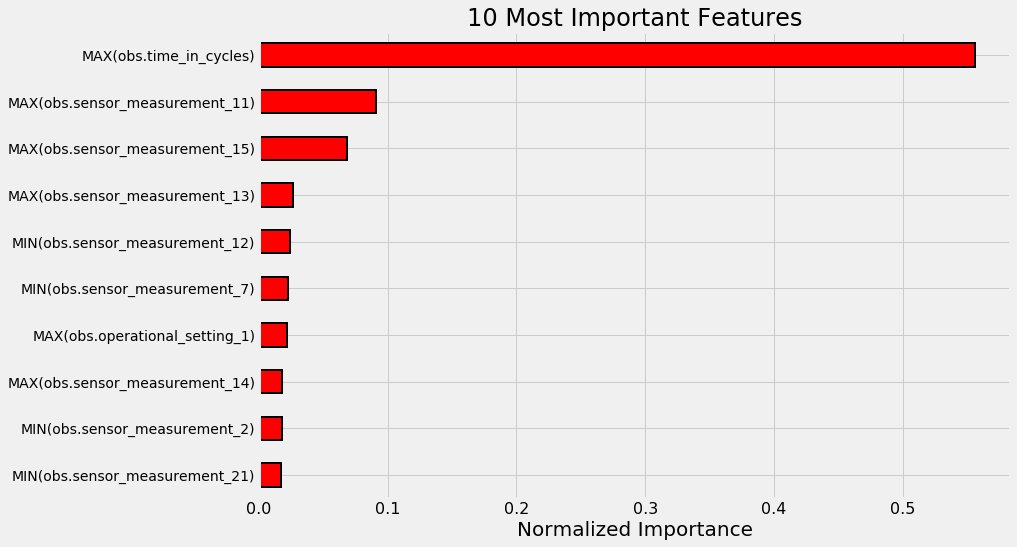

In [12]:
norm_fi = plot_feature_importances(fi, 10, color = 'red')

Right out of the box, we see very good results from Automated Feature Engineering. Moreover, the most important feature makes intuitive sense: the total number of previous cycles is likely the most indicative indicator of when an engine will fail. We can also see that __Sensor Measurement 16__ is very important which could indicate to the engineers they should focus on this measure. 

In [13]:
feature_matrix.to_csv('../input/feature_matrix_simple.csv')

# Comparison to Manual Features

We can take a look at the manual engineered features to see if there is overlap between features. We'll examine the correlations between the features and look at the top 10 most important automated features.

In [15]:
auto = pd.read_csv('../input/feature_matrix_simple.csv', index_col = 0)
manual = pd.read_csv('../input/simple_manual_features.csv')
auto.head()

,MIN(obs.operational_setting_1),MIN(obs.sensor_measurement_10),MIN(obs.sensor_measurement_11),MIN(obs.sensor_measurement_12),MIN(obs.sensor_measurement_13),MIN(obs.sensor_measurement_15),MIN(obs.sensor_measurement_17),MIN(obs.sensor_measurement_2),MIN(obs.sensor_measurement_20),MIN(obs.sensor_measurement_21),...,MAX(obs.sensor_measurement_13),MAX(obs.sensor_measurement_14),MAX(obs.sensor_measurement_15),MAX(obs.time_in_cycles),MEAN(obs.operational_setting_1),MEAN(obs.operational_setting_3),MEAN(obs.sensor_measurement_10),MEAN(obs.sensor_measurement_11),MEAN(obs.sensor_measurement_14),MEAN(obs.sensor_measurement_15)
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0000,0.94,36.57,129.63,2027.94,8.3892,306,536.25,10.36,6.2655,...,2388.25,8128.64,10.9520,119,25.414484,93.277311,1.083109,42.763866,8043.524286,9.390416
2,0.0000,0.94,36.51,129.80,2028.29,8.4025,305,536.21,10.37,6.2350,...,2388.25,8151.95,10.9374,142,23.734917,93.239437,1.090845,42.814366,8064.478873,9.357582
3,0.0002,0.94,36.33,130.27,2028.18,8.3688,304,536.12,10.41,6.2373,...,2388.13,8143.37,10.9014,80,25.365650,94.500000,1.089875,42.627625,8065.366875,9.299904
4,0.0004,0.94,36.54,130.11,2028.23,8.3926,305,536.08,10.44,6.2519,...,2388.16,8142.98,10.9280,80,23.640294,96.000000,1.105125,43.317875,8075.063875,9.216681
5,0.0008,0.94,36.53,130.15,2028.30,8.3771,305,536.27,10.48,6.3157,...,2388.18,8150.15,10.9048,32,21.721191,93.750000,1.111250,42.915000,8069.967813,9.248366


In [16]:
mcols = []
acols = []
corrs = []
for mcol in manual:
    for acol in auto:
        mcols.append(mcol)
        acols.append(acol)
        corrs.append(np.corrcoef(manual[mcol].values, auto[acol].values)[0, 1])

In [17]:
corr_df = pd.DataFrame({'Automated Feature': acols, 'Manual Feature': mcols, 'Correlation': corrs})
top_10 = corr_df.loc[corr_df['Automated Feature'].isin(norm_fi.head(10)['feature'])]

In [18]:
top_10.sort_values('Correlation').tail(10)

,Automated Feature,Manual Feature,Correlation
1017,MIN(obs.sensor_measurement_21),sensor_measurement_21-min,1.0
931,MIN(obs.sensor_measurement_2),sensor_measurement_2-min,1.0
71,MAX(obs.operational_setting_1),operational_setting_1-max,1.0
507,MIN(obs.sensor_measurement_12),sensor_measurement_12-min,1.0
1133,MIN(obs.sensor_measurement_7),sensor_measurement_7-min,1.0
635,MAX(obs.sensor_measurement_14),sensor_measurement_14-max,1.0
720,MAX(obs.sensor_measurement_15),sensor_measurement_15-max,1.0
437,MAX(obs.sensor_measurement_11),sensor_measurement_11-max,1.0
578,MAX(obs.sensor_measurement_13),sensor_measurement_13-max,1.0
1253,MAX(obs.time_in_cycles),time_in_cycles-max,1.0


For each of the 10 most important features from automated feature engineering, we find the exact same feature in the manual features. This raises the question of why even build the manual features in the first place.

# Advanced Featuretools

In the manual feature engineering notebook, we saw that performance improved when we included a number of advanced operations dealing with clustering and time-series. In this notebook we'll use both the clustering and the time-series analysis. The clustering will be included by adding a column with the cluster assignment to the original dataframe and then remaking the entity. The time-series methods will be added using custom primitives.

In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 10)

# Need to impute the missing values
imputer = Imputer(strategy='median')
train_cluster = imputer.fit_transform(train.drop(columns = ['engine_no', 'time_in_cycles', 'index', 'time']))
test_cluster = imputer.transform(test.drop(columns = ['engine_no', 'time_in_cycles', 'index', 'time']))

# Create a new column with the cluster label
train['cluster'] = kmeans.fit_predict(train_cluster)
test['cluster'] = kmeans.predict(test_cluster)

# Redefine the entityset
es = ft.EntitySet(id = 'engines')
es = es.entity_from_dataframe(dataframe = train,
                              entity_id='obs', 
                              index = 'index',
                              time_index = 'time')

es.normalize_entity(base_entity_id='obs',
                    new_entity_id = 'engines', 
                    index = 'engine_no')

# Redefine the test entityset
test_es = ft.EntitySet(id = 'test_engines')
test_es = test_es.entity_from_dataframe(dataframe = test,
                                        entity_id='obs', 
                                        index = 'index',
                                        time_index = 'time')

test_es.normalize_entity(base_entity_id='obs',
                         new_entity_id = 'engines', 
                         index = 'engine_no')

Entityset: test_engines
  Entities:
    obs [Rows: 33991, Columns: 34]
    engines [Rows: 259, Columns: 2]
  Relationships:
    obs.engine_no -> engines.engine_no

## Custom Primitives 

The time-series methods can be used in the form of custom primitives. 
Each custom primitive we make is an `agg` because it takes multiple children observations and computes a single number. (A transform primitive acts on a single column and returns as many values as there are numbers in the column). 

Featuretools already sort entities by the `time_index` if provided with one, so the time-series operations will be applied to the data in the correct order. For each custom primitive we provide:

* The function. Here we use anonymous `lambda` functions but we could define them as complete functions.
* The input types accepted by the primitive. All of these time-series methods act on numbers so we limit the input types to `Numeric`.
* The return type of the function. These methods return a single `Numeric` number
* A name for the primitive

These parameters will change depending on the proble and the function. All of the custom primitives below are `agg` and take and return `Numeric` datatypes, but in theory custom primitives can have much wider applications. 

In [20]:
from tsfresh.feature_extraction.feature_calculators import (cid_ce, number_peaks, 
                                                             last_location_of_maximum, 
                                                             skewness, sample_entropy)

import featuretools.variable_types as vtypes
from featuretools.primitives import make_agg_primitive

In [21]:
cid_ce_primitive = make_agg_primitive(lambda x: cid_ce(x , False),
                                      input_types = [vtypes.Numeric],
                                      return_type = vtypes.Numeric,
                                      name = 'Complexity')

number_peaks_primitive = make_agg_primitive(lambda x: number_peaks(x , 5),
                                            input_types = [vtypes.Numeric],
                                            return_type = vtypes.Numeric,
                                            name = 'NumberPeaks')

last_location_of_maximum_primititive = make_agg_primitive(lambda x: last_location_of_maximum(x),
                                                          input_types = [vtypes.Numeric],
                                                          return_type = vtypes.Numeric,
                                                          name = 'LastLocationMax')

skewness_primitive = make_agg_primitive(lambda x: skewness(x),
                                        input_types = [vtypes.Numeric],
                                        return_type = vtypes.Numeric,
                                        name = 'Skewness')

sample_entropy_primitive = make_agg_primitive(lambda x: sample_entropy(x),
                                              input_types = [vtypes.Numeric],
                                              return_type = vtypes.Numeric,
                                              name = 'Entropy')

Now we use the `ft.dfs` call but add in the primitives we built. We'll also add in three more aggregation primitives: `skew`, `std`, and `trend`. Ahead of time we don't know if these will be important, but there's no way to find out until we calculate them, build a model, and test the model with the features. 

In [22]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='engines',
                                       agg_primitives = ['min', 'max', 'mean', 
                                                         'count', 'sum', 'last',
                                                         'skew', 'std', 'trend',
                                                         cid_ce_primitive, number_peaks_primitive, 
                                                         last_location_of_maximum_primititive,
                                                         skewness_primitive, sample_entropy_primitive],
                                       trans_primitives = ['cum_mean', 'cum_sum'],
                                       max_depth = 1, n_jobs = -1, verbose = 1,
                                       chunk_size = 100)
feature_matrix.head()

tornado.application - ERROR - Future <tornado.concurrent.Future object at 0x10a013be0> exception was never retrieved: Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1069, in run
    yielded = self.gen.send(value)
  File "/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 805, in _handle_report
    msgs = yield self.scheduler_comm.comm.read()
AttributeError: 'NoneType' object has no attribute 'comm'


Built 404 features
EntitySet scattered to workers in 1.505 seconds
Elapsed: 01:19 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 3/3 chunks


,MIN(obs.operational_setting_1),MIN(obs.operational_setting_2),MIN(obs.operational_setting_3),MIN(obs.sensor_measurement_1),MIN(obs.sensor_measurement_10),MIN(obs.sensor_measurement_11),MIN(obs.sensor_measurement_12),MIN(obs.sensor_measurement_13),MIN(obs.sensor_measurement_14),MIN(obs.sensor_measurement_15),...,ENTROPY(obs.sensor_measurement_26),ENTROPY(obs.sensor_measurement_3),ENTROPY(obs.sensor_measurement_4),ENTROPY(obs.sensor_measurement_5),ENTROPY(obs.sensor_measurement_6),ENTROPY(obs.sensor_measurement_7),ENTROPY(obs.sensor_measurement_8),ENTROPY(obs.sensor_measurement_9),ENTROPY(obs.time_in_cycles),ENTROPY(obs.cluster)
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0000,0.0,60.0,445.0,0.94,36.57,129.63,2027.94,7857.51,8.3892,...,inf,1.260269,1.297623,1.666739,1.450558,1.450558,1.215096,1.215096,2.315631,1.666739
2,0.0000,0.0,60.0,445.0,0.94,36.51,129.80,2028.29,7875.70,8.4025,...,inf,1.317122,1.452252,1.765438,1.540545,1.540545,1.285559,1.285921,2.208374,1.861566
3,0.0002,0.0,60.0,445.0,0.94,36.33,130.27,2028.18,7868.28,8.3688,...,inf,1.203973,1.333294,1.714447,1.714447,1.505819,1.114240,1.161633,2.321755,2.087065
4,0.0004,0.0,60.0,445.0,0.94,36.54,130.11,2028.23,7870.69,8.3926,...,inf,1.261504,1.405464,1.716206,1.596859,1.596859,1.212447,1.227453,2.321755,2.087065
5,0.0008,0.0,60.0,445.0,0.94,36.53,130.15,2028.30,7876.75,8.3771,...,inf,1.386294,1.581603,1.929910,1.581603,1.581603,1.339041,1.354546,2.772589,2.112231


In [23]:
test_feature_matrix = ft.calculate_feature_matrix(entityset=test_es, 
                                                  features=feature_names,
                                                  n_jobs = -1, verbose = 1,
                                                  chunk_size = 100)

# Apply feature selection
feature_matrix = feature_selection(feature_matrix)
test_feature_matrix = test_feature_matrix[feature_matrix.columns]

EntitySet scattered to workers in 1.562 seconds
Elapsed: 01:50 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 3/3 chunks
Original shape:  (260, 404)
40 missing columns with threshold: 90.
41 zero variance columns.
213 collinear columns removed with threshold: 0.95.
Total columns removed:  294
Shape after feature selection: (260, 110).


In [24]:
feature_matrix.to_csv('../input/feature_matrix1.csv')
test_feature_matrix.to_csv('../input/test_feature_matrix1.csv')

### Evaluate Custom Primitive Features

We'll take the enriched and selected set of features and `evaluate` them. Then we can look at the feature importances to see if any of the time-series custom primitives were of use. 

5-fold CV MAPE: 46.27 with std: 4.91
Test MAPE: 56.09.


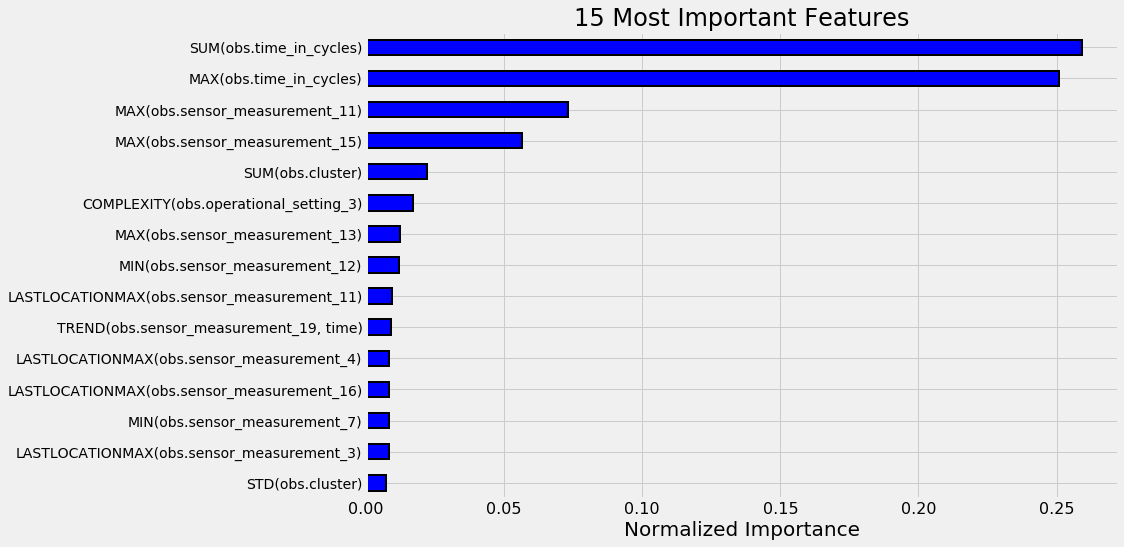

In [25]:
preds, fi = evaluate(feature_matrix, train_labels, test_feature_matrix, test_labels)
norm_fi = plot_feature_importances(fi)

The last location of maximum value seems to be relatively important. We also see the Complexity of Sensor Measurement 16 in the top 3 most important features reflecting our finding in the manual feature engineering that this sensor measurement was among the most meaningful. As with the manual feature engineering, by far the most important feature is derived from the time in cycles, a direct measurement of the time the engine has been running. 

# Increase Max Depth 

Another method for generating more features is to increase the maximum depth of the features. This will mean featuretools, stacks more primitives on top of one another leading to a significant increase in the number of features. We can use the same exact primitives but increase the maximum depth to 2 and evaluate the results.

In [26]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='engines',
                                       agg_primitives = ['min', 'max', 'mean', 
                                                         'count', 'sum', 'last',
                                                         'skew', 'std', 'trend',
                                                         cid_ce_primitive, number_peaks_primitive, 
                                                         last_location_of_maximum_primititive,
                                                         skewness_primitive, sample_entropy_primitive],
                                       trans_primitives = ['cum_mean', 'cum_sum'],
                                       max_depth = 2, n_jobs = -1, verbose = 1,
                                       chunk_size = 100)
feature_matrix.head()

Built 1210 features
EntitySet scattered to workers in 1.569 seconds
Elapsed: 03:21 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 3/3 chunks


,MIN(obs.operational_setting_1),MIN(obs.operational_setting_2),MIN(obs.operational_setting_3),MIN(obs.sensor_measurement_1),MIN(obs.sensor_measurement_10),MIN(obs.sensor_measurement_11),MIN(obs.sensor_measurement_12),MIN(obs.sensor_measurement_13),MIN(obs.sensor_measurement_14),MIN(obs.sensor_measurement_15),...,ENTROPY(obs.CUM_SUM(sensor_measurement_10 by engine_no)),ENTROPY(obs.CUM_SUM(sensor_measurement_25 by engine_no)),ENTROPY(obs.CUM_SUM(sensor_measurement_17 by engine_no)),ENTROPY(obs.CUM_SUM(operational_setting_2 by engine_no)),ENTROPY(obs.CUM_SUM(operational_setting_3 by engine_no)),ENTROPY(obs.CUM_SUM(sensor_measurement_7 by engine_no)),ENTROPY(obs.CUM_SUM(sensor_measurement_11 by engine_no)),ENTROPY(obs.CUM_SUM(sensor_measurement_16 by engine_no)),ENTROPY(obs.CUM_SUM(sensor_measurement_8 by engine_no)),ENTROPY(obs.CUM_SUM(sensor_measurement_2 by engine_no))
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0000,0.0,60.0,445.0,0.94,36.57,129.63,2027.94,7857.51,8.3892,...,2.262247,inf,2.271870,2.262247,2.269111,2.215479,2.276022,2.223343,2.284378,2.277410
2,0.0000,0.0,60.0,445.0,0.94,36.51,129.80,2028.29,7875.70,8.4025,...,2.249196,inf,2.239771,2.234158,2.267353,2.212930,2.240710,2.249196,2.236026,2.236961
3,0.0002,0.0,60.0,445.0,0.94,36.33,130.27,2028.18,7868.28,8.3688,...,2.318534,inf,2.321755,2.274502,2.299426,2.293136,2.321755,2.296276,2.321755,2.321755
4,0.0004,0.0,60.0,445.0,0.94,36.54,130.11,2028.23,7870.69,8.3926,...,2.308934,inf,2.321755,2.253192,2.296276,2.265314,2.321755,2.318534,2.321755,2.321755
5,0.0008,0.0,60.0,445.0,0.94,36.53,130.15,2028.30,7876.75,8.3771,...,2.651228,inf,2.710068,2.236284,2.517696,2.335375,2.710068,2.543014,2.710068,2.740840


Increasing the maximum depth tripled the number of features created. While some of these won't be useful, that will be up to the model to decide (rather than depending on our own judgement in manual feature engineering). We'll want to make the same features for the test data, perform feature selection, and then evaluate the feature matrix. 

In [27]:
test_feature_matrix = ft.calculate_feature_matrix(entityset=test_es, 
                                                  features=feature_names,
                                                  n_jobs = -1, verbose = 1,
                                                  chunk_size = 100)

# Apply feature selection
feature_matrix = feature_selection(feature_matrix)
test_feature_matrix = test_feature_matrix[feature_matrix.columns]

EntitySet scattered to workers in 1.699 seconds
Elapsed: 04:36 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 3/3 chunks
Original shape:  (260, 1210)
120 missing columns with threshold: 90.
149 zero variance columns.
706 collinear columns removed with threshold: 0.95.
Total columns removed:  975
Shape after feature selection: (260, 235).


5-fold CV MAPE: 47.63 with std: 4.67
Test MAPE: 55.77.


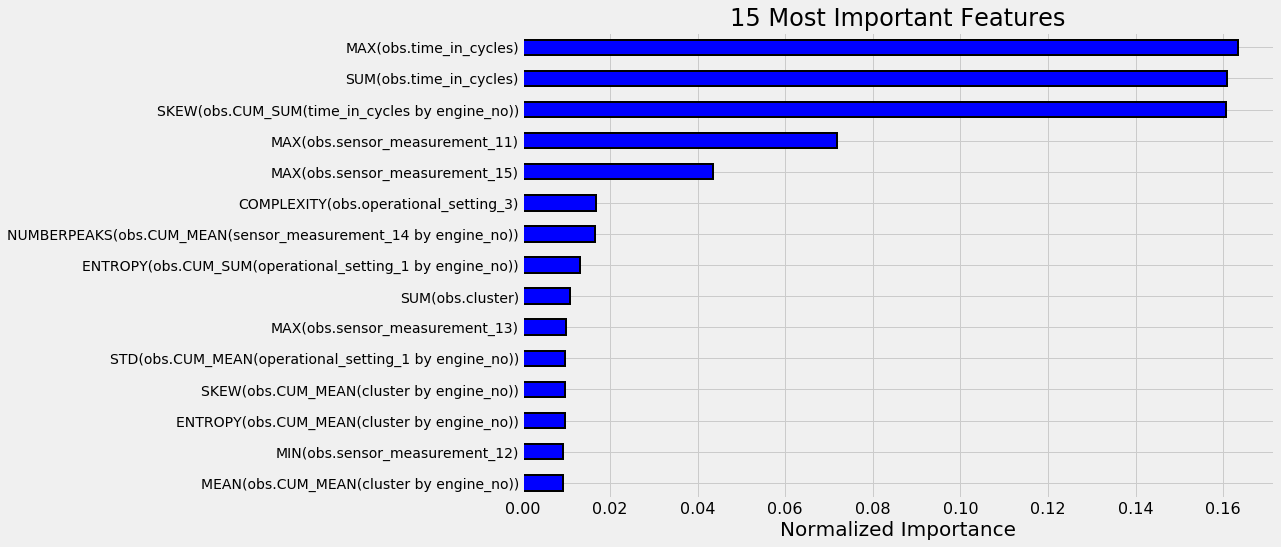

In [28]:
preds, fi = evaluate(feature_matrix, train_labels, test_feature_matrix, test_labels)
norm_fi = plot_feature_importances(fi)

It looks like increasing the maximum depth may not be helpful because the cross validation score decreases. The most important features now are significantly different than with the smaller feature matrix and it's possible the greater number of variables is drowning out the signal from some the of the more important variables.

## Random Search

The final step, just as with manual feature engineering, is to optimize the Random Forest model for our dataset. This will be done with 100 iterations of random search using 5-fold cross validation. For the features, we'll use those that performed best in cross-validation (because using the testing scores would be cheating.) These were the second set of features, with the custom primitives and a max depth of 1. 

In [29]:
feature_matrix = pd.read_csv('../input/feature_matrix1.csv')
test_feature_matrix = pd.read_csv('../input/test_feature_matrix1.csv')

In [30]:
best_model = random_search(feature_matrix, train_labels)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.0min


Best 5-fold CV Score: 44.76 with std: 3.94.

Best Hyperparameters:
{'n_estimators': 69, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': None}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.4min finished


In [31]:
from sklearn.preprocessing import Imputer

# Impute the missing values
imputer = Imputer(strategy = 'median', axis = 1)
train = imputer.fit_transform(feature_matrix.replace({np.inf:np.nan}))
test = imputer.transform(test_feature_matrix.replace({np.inf:np.nan}))

In [32]:
predictions = best_model.predict(test)
final_mape = 100 * np.mean(abs(predictions - test_labels) / test_labels)
print('Final Test MAPE: {:.2f}.'.format(final_mape))

Final Test MAPE: 53.10.


In [33]:
# fi = pd.DataFrame({'feature': feature_matrix.columns,
#                    'importance': best_model.feature_importances_})
# norm_fi = plot_feature_importances(fi)

## Just for Fun: Dimensionality Reduction with UMAP

As a slight diversion, we can use UMAP on the final dataset to see if there is a clean separation of engines in terms of the labels. We'll use UMAP to reduce the number of dimensions from 80 to three, and then visualize the matrix colored by the label.

In [36]:
from umap import UMAP

feature_matrix_ready = imputer.fit_transform(feature_matrix.replace({np.inf: np.nan}))

umap = UMAP(n_components = 3)
train_embedding = umap.fit_transform(feature_matrix_ready)

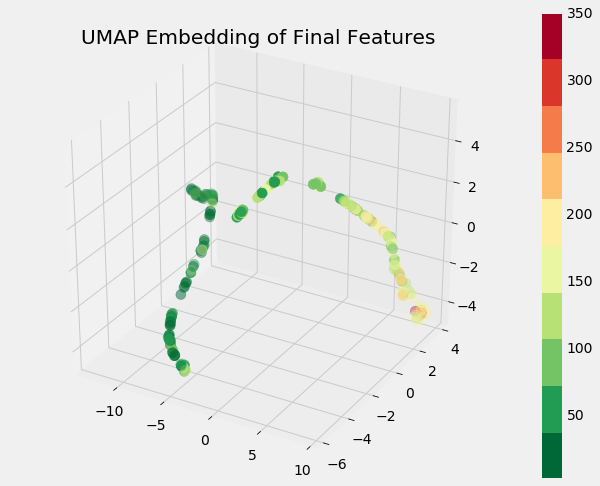

In [37]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection='3d')

cmap = plt.get_cmap('RdYlGn_r', 10)
p = ax.scatter(train_embedding[:, 0], train_embedding[:, 1], train_embedding[:, 2], 
               c = train_labels, cmap = cmap, s = 100)
plt.title('UMAP Embedding of Final Features')
fig.colorbar(p);

There is some separation of data based on the labels. If we wanted, we could use these embeddings as features in a model.

# Conclusions

Following are the complete results from the manual and automated feature engineering (this may change depending on the run because even setting random seeds did not seem to ensure stable results):

| Feature Set                                                      	| Model                    	| Number of Features   (before selection) 	| Number of Features   (after selection) 	| Time to Build 	| 5-fold Train CV MAPE 	| Test MAPE 	|
|------------------------------------------------------------------	|--------------------------	|-----------------------------------------	|----------------------------------------	|---------------	|----------------------	|-----------	|
| Baseline Average Train Label Guess                               	| -                        	| -                                       	| -                                      	| 15 seconds    	| 158.89 (0.00)        	| 226.44    	|
| Baseline Half Life Guess                                         	| -                        	| -                                       	| -                                      	| 30 seconds    	| 614.89 (0.00)        	| 926.51    	|
| Simple Aggregations (No Feature Selection)                       	| Default Random Forest    	| 150                                     	| 150                                    	| 120 minutes    	| 44.56 (3.22)         	| 232.47    	|
| Simple Aggregations                      	| Default Random Forest    	| 150                                     	| 42                                     	| 120 minutes    	| 46.62 (4.46)         	| 51.48     	|
| Simple Aggregations +  Percent Change and Cumuluative Sum        	| Default Random Forest    	| 455                                     	| 88                                     	| 150 minutes   	| 46.13 (4.93)         	| 53.11     	|
| Simple Aggregations + KMeans Clustering and Time-Series Analysis 	| Default Random Forest    	| 305                                     	| 88                                     	| 180 minutes   	| 45.36 (5.35)         	| 50.33     	|
| Simple Aggregations + KMeans Clustering and Time-Series Analysis 	| Optimized Random Forest  	| 305                                     	| 88                                     	| 180 minutes   	| 45.33 (5.98)         	| 48.54     	|
| Featuretools Basic                                               	| Default Random Forest    	| 151                                     	| 42                                     	| 15 minutes    	| 46.40 (5.77)         	| 50.38     	|
| Featuretools with Custom Primitives  (max depth 1)               	| Default Random Forest    	| 404                                     	| 103                                    	| 30 minutes    	| 45.45 (5.27)         	| 51.56     	|
| Featuretools with Custom Primitives (max depth 2)                	| Default Random Forest    	| 1210                                    	| 231                                    	| 35 minutes    	| 48.12 (6.41)         	| 53.55     	|
| Featuretools with Custom Primitives (max depth 1)                	| Optimized Random  Forest 	| 404                                     	| 103                                    	| 45 minutes    	| 45.57 (5.41)         	| 50.87     	|

The main takeaways are as follows:

* Featureools and manual feature engineering both significantly improve upon the baseline
* Featuretools is 8x faster than even the simplest manual feature engineering
* Performance between featuretools and manual is essentially the same with small gains to more intricate work
* Feature engineering has a much greater affect on performance than hyperparameter tuning

The basic featuretools model performed around the same level of the best manual feature engineering and was 8x faster than even the fastest manual built model. Adding custom primitives improved the cross validation score but decreasse the score on the testing set indicating the extra features may lead to overfitting. Overall, we can conclude __Featuretools delivers nearly the same performance as the most intricate manual feature engineering but at a fraction of the time for development.__ 